- the goal is to predict which patients will develop heart disease
- numerical data 13 features and 1 label
- score is 0-4 (no heart disease - severe disease)

###Process
- import data
- clean data
- build FFN (bianarize the classification)
- maximize accuracy
- plot train/test loss and accuracy

In [171]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import scipy.stats as stats

# for number-crunching
import numpy as np

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

<ipython-input-171-dadfcb8e8565>:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [172]:
# import the data
url  = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
data = pd.read_csv(url,sep=',',header=None)
data.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','DISEASE']


# data contain some ?'s; replace with NaN and drop those rows
data = data.replace('?',np.nan).dropna()
data = data[data['chol'] < 500] # drop an outlier
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,DISEASE
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3


<ipython-input-173-01da74068307>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


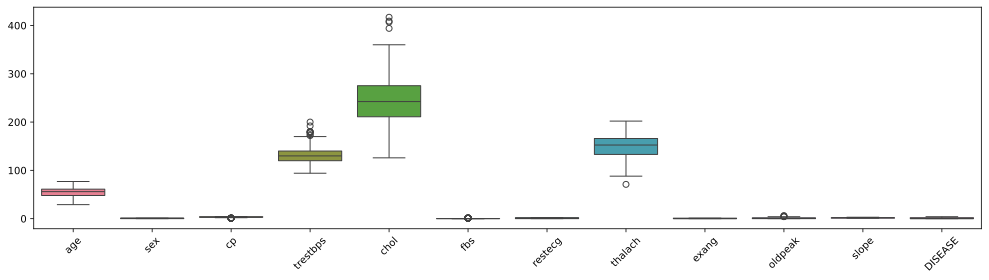

In [173]:
# check the distributions
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [174]:
# columns ca and thal are objects not floats
objectCols = ['ca', 'thal']
data[objectCols] = data[objectCols].astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       296 non-null    float64
 1   sex       296 non-null    float64
 2   cp        296 non-null    float64
 3   trestbps  296 non-null    float64
 4   chol      296 non-null    float64
 5   fbs       296 non-null    float64
 6   restecg   296 non-null    float64
 7   thalach   296 non-null    float64
 8   exang     296 non-null    float64
 9   oldpeak   296 non-null    float64
 10  slope     296 non-null    float64
 11  ca        296 non-null    float64
 12  thal      296 non-null    float64
 13  DISEASE   296 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 34.7 KB


In [175]:
# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop(['sex', 'fbs', 'exang','DISEASE'])
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data['DISEASE'][data['DISEASE']>0] = 1

<ipython-input-175-4101c78eac33>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DISEASE'][data['DISEASE']>0] = 1


In [176]:
dataT = torch.tensor(data[data.keys().drop('DISEASE')].values).float()
labels = torch.tensor(data['DISEASE'].values).float()
labels = labels[:,None]
dataT.shape, labels.shape

(torch.Size([296, 13]), torch.Size([296, 1]))

In [177]:
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size= 0.2)

train_set = TensorDataset(train_data, train_labels)
test_set = TensorDataset(test_data, test_labels)

batchSize= 8
train_loader = DataLoader(train_set, batch_size=batchSize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=test_set.tensors[0].shape[0])

#Create Model

In [186]:
def createModel():
  class HeartDiseaseModel(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(13,16)
      self.fc1 = nn.Linear(16,32)
      self.fc2 = nn.Linear(32,32)
      self.output = nn.Linear(32,1)

    def forward(self, x):
      x = F.relu(self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)

  model = HeartDiseaseModel()
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.04)

  return model, lossfun,optimizer

In [179]:
epochs = 500
def trainModel(train_loader, test_loader):
  model, lossfun, optimizer = createModel()

  trainLosses = np.zeros(epochs)
  testLosses = np.zeros(epochs)

  trainAcc = []
  testAcc = []

  for epoch in range(epochs):
    batchLoss = []
    batchAcc = []
    model.train()
    for X,y in train_loader:
      yHat = model(X)
      loss = lossfun(yHat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())

      batchAcc.append(100*torch.mean(((yHat>0)==y).float()).item())

    trainAcc.append(np.mean(batchAcc))
    trainLosses[epoch] = np.mean(batchLoss)

    model.eval()
    X,y = next(iter(test_loader))
    with torch.no_grad():
      yHat = model(X)
      loss = lossfun(yHat, y)

    testAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
    testLosses[epoch] = loss.item()
  return trainAcc, testAcc, trainLosses, testLosses


In [ ]:
# trainAcc, testAcc, trainLosses, testLosses = trainModel(train_loader, test_loader)


In [187]:
# with 2 hidden layers
for i in range(5):
  trainAcc, testAcc, trainLosses, testLosses = trainModel(train_loader, test_loader)
  print(f'Iteration {i+1}, Train/Test Accuracies: {np.mean(trainAcc[-5:])}%, {np.mean(testAcc[-5:])}%, Train/Test Loss: {trainLosses[-1]}, {testLosses[-1]}')


Iteration 1, Train/Test Accuracies: 86.55172413793105%, 82.66666531562805%, Train/Test Loss: 0.32618626592488126, 0.381273090839386
Iteration 2, Train/Test Accuracies: 86.55172413793103%, 81.99999928474426%, Train/Test Loss: 0.3284496495435978, 0.3899663984775543
Iteration 3, Train/Test Accuracies: 86.98275862068967%, 81.66666626930237%, Train/Test Loss: 0.3212709254745779, 0.39393144845962524
Iteration 4, Train/Test Accuracies: 86.8103448275862%, 81.66666626930237%, Train/Test Loss: 0.33553247050992374, 0.3943111002445221
Iteration 5, Train/Test Accuracies: 86.46551724137933%, 81.66666626930237%, Train/Test Loss: 0.3321251080467783, 0.3917193114757538


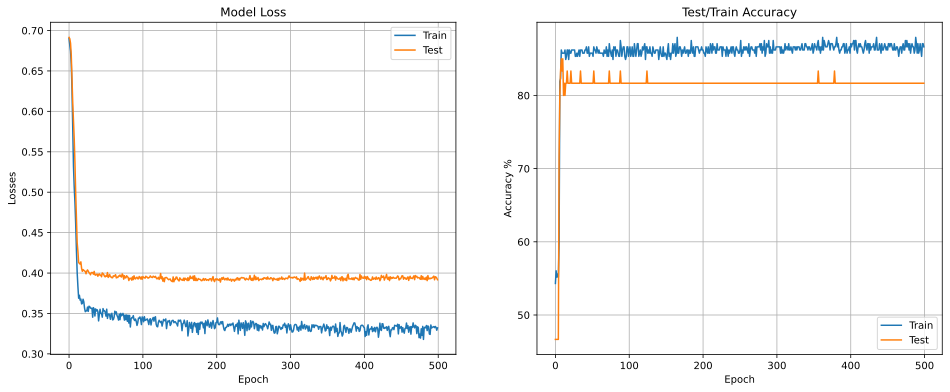

In [188]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

ax[0].plot(trainLosses)
ax[0].plot(testLosses)
ax[0].legend(['Train', 'Test'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Losses')
ax[0].set_title('Model Loss')
ax[0].grid()

ax[1].plot(trainAcc)
ax[1].plot(testAcc)
ax[1].legend(['Train', 'Test'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy %')
ax[1].set_title('Test/Train Accuracy')
ax[1].grid()